# Marketing KPI Data Cleaning & Feature Engineering
This notebook performs:
- Data loading
- Cleaning & preprocessing
- KPI calculations (CAC, ROAS, Conversion Rate)
- Region generation
- Anomaly injection
- Export of processed dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("C:/Users/DarshBorse/Scikit/kpi/marketing_campaign_dataset.csv")
df.head()

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date
0,1,Innovate Industries,Email,Men 18-24,30 days,Google Ads,0.04,"$16,174.00",6.29,Chicago,Spanish,506,1922,6,Health & Wellness,2021-01-01
1,2,NexGen Systems,Email,Women 35-44,60 days,Google Ads,0.12,"$11,566.00",5.61,New York,German,116,7523,7,Fashionistas,2021-01-02
2,3,Alpha Innovations,Influencer,Men 25-34,30 days,YouTube,0.07,"$10,200.00",7.18,Los Angeles,French,584,7698,1,Outdoor Adventurers,2021-01-03
3,4,DataTech Solutions,Display,All Ages,60 days,YouTube,0.11,"$12,724.00",5.55,Miami,Mandarin,217,1820,7,Health & Wellness,2021-01-04
4,5,NexGen Systems,Email,Men 25-34,15 days,YouTube,0.05,"$16,452.00",6.50,Los Angeles,Mandarin,379,4201,3,Health & Wellness,2021-01-05


In [3]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['campaign_id', 'company', 'campaign_type', 'target_audience',
       'duration', 'channel_used', 'conversion_rate', 'acquisition_cost',
       'roi', 'location', 'language', 'clicks', 'impressions',
       'engagement_score', 'customer_segment', 'date'],
      dtype='object')

In [4]:
# Convert date column if exists
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   campaign_id       200000 non-null  int64         
 1   company           200000 non-null  object        
 2   campaign_type     200000 non-null  object        
 3   target_audience   200000 non-null  object        
 4   duration          200000 non-null  object        
 5   channel_used      200000 non-null  object        
 6   conversion_rate   200000 non-null  float64       
 7   acquisition_cost  200000 non-null  object        
 8   roi               200000 non-null  float64       
 9   location          200000 non-null  object        
 10  language          200000 non-null  object        
 11  clicks            200000 non-null  int64         
 12  impressions       200000 non-null  int64         
 13  engagement_score  200000 non-null  int64         
 14  cust

In [5]:
# Drop missing values
df = df.dropna()

In [6]:
df['acquisition_cost'] = (
    df['acquisition_cost']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
)

df['acquisition_cost'] = pd.to_numeric(df['acquisition_cost'], errors='coerce')
df['acquisition_cost'].head()

0    16174.0
1    11566.0
2    10200.0
3    12724.0
4    16452.0
Name: acquisition_cost, dtype: float64

In [7]:
# Remove invalid rows for safe KPI calculation
if 'conversions_rate' in df.columns:
    df = df[df['conversions_rate'] > 0]
if 'clicks' in df.columns:
    df = df[df['clicks'] > 0]
if 'aquisition_cost' in df.columns:
    df = df[df['aquisition_cost'] > 0]

In [8]:
# KPI Calculations
df['revenue'] = df['acquisition_cost'] * (1 + df['roi'])
df['conversions'] = df['clicks'] * df['conversion_rate']

df['cac'] = df['acquisition_cost'] / df['conversions']
df['roas'] = df['revenue'] / df['acquisition_cost']
df.head()

,campaign_id,company,campaign_type,target_audience,duration,channel_used,conversion_rate,acquisition_cost,roi,location,language,clicks,impressions,engagement_score,customer_segment,date,revenue,conversions,cac,roas
0,1,Innovate Industries,Email,Men 18-24,30 days,Google Ads,0.04,16174.0,6.29,Chicago,Spanish,506,1922,6,Health & Wellness,2021-01-01,117908.46,20.24,799.110672,7.29
1,2,NexGen Systems,Email,Women 35-44,60 days,Google Ads,0.12,11566.0,5.61,New York,German,116,7523,7,Fashionistas,2021-01-02,76451.26,13.92,830.890805,6.61
2,3,Alpha Innovations,Influencer,Men 25-34,30 days,YouTube,0.07,10200.0,7.18,Los Angeles,French,584,7698,1,Outdoor Adventurers,2021-01-03,83436.00,40.88,249.510763,8.18
3,4,DataTech Solutions,Display,All Ages,60 days,YouTube,0.11,12724.0,5.55,Miami,Mandarin,217,1820,7,Health & Wellness,2021-01-04,83342.20,23.87,533.054043,6.55
4,5,NexGen Systems,Email,Men 25-34,15 days,YouTube,0.05,16452.0,6.50,Los Angeles,Mandarin,379,4201,3,Health & Wellness,2021-01-05,123390.00,18.95,868.179420,7.50


In [9]:
# Add synthetic region column
regions = ['North', 'South', 'East', 'West']
df['region'] = np.random.choice(regions, size=len(df))

In [10]:
# Inject 2% anomaly spikes in spend
anomaly_indices = df.sample(frac=0.02, random_state=42).index
df.loc[anomaly_indices, 'acquisition_cost'] *= 3

In [11]:
df['target_audience'].unique()[:10]

array(['Men 18-24', 'Women 35-44', 'Men 25-34', 'All Ages', 'Women 25-34'],
      dtype=object)

In [12]:
df['gender'] = df['target_audience'].str.extract(r'^(Men|Women)')

In [13]:
df['age_range'] = df['target_audience'].str.extract(r'(\d{2}-\d{2})')

In [14]:
df.loc[df['target_audience'] == 'All Ages', 'gender'] = 'All'
df.loc[df['target_audience'] == 'All Ages', 'age_range'] = 'All'


In [15]:
df = df.drop(columns=['target_audience'])
# Select only object columns
object_cols = df.select_dtypes(include='object').columns

# Convert them to lowercase
df[object_cols] = df[object_cols].apply(lambda x: x.str.lower())
df.head()

,campaign_id,company,campaign_type,duration,channel_used,conversion_rate,acquisition_cost,roi,location,language,...,engagement_score,customer_segment,date,revenue,conversions,cac,roas,region,gender,age_range
0,1,innovate industries,email,30 days,google ads,0.04,16174.0,6.29,chicago,spanish,...,6,health & wellness,2021-01-01,117908.46,20.24,799.110672,7.29,west,men,18-24
1,2,nexgen systems,email,60 days,google ads,0.12,11566.0,5.61,new york,german,...,7,fashionistas,2021-01-02,76451.26,13.92,830.890805,6.61,south,women,35-44
2,3,alpha innovations,influencer,30 days,youtube,0.07,10200.0,7.18,los angeles,french,...,1,outdoor adventurers,2021-01-03,83436.00,40.88,249.510763,8.18,west,men,25-34
3,4,datatech solutions,display,60 days,youtube,0.11,12724.0,5.55,miami,mandarin,...,7,health & wellness,2021-01-04,83342.20,23.87,533.054043,6.55,east,all,all
4,5,nexgen systems,email,15 days,youtube,0.05,49356.0,6.50,los angeles,mandarin,...,3,health & wellness,2021-01-05,123390.00,18.95,868.179420,7.50,east,men,25-34


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   campaign_id       200000 non-null  int64         
 1   company           200000 non-null  object        
 2   campaign_type     200000 non-null  object        
 3   duration          200000 non-null  object        
 4   channel_used      200000 non-null  object        
 5   conversion_rate   200000 non-null  float64       
 6   acquisition_cost  200000 non-null  float64       
 7   roi               200000 non-null  float64       
 8   location          200000 non-null  object        
 9   language          200000 non-null  object        
 10  clicks            200000 non-null  int64         
 11  impressions       200000 non-null  int64         
 12  engagement_score  200000 non-null  int64         
 13  customer_segment  200000 non-null  object        
 14  date

In [17]:
df['duration'] = df['duration'].str.replace('days', '', regex=False)
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   campaign_id       200000 non-null  int64         
 1   company           200000 non-null  object        
 2   campaign_type     200000 non-null  object        
 3   duration          200000 non-null  int64         
 4   channel_used      200000 non-null  object        
 5   conversion_rate   200000 non-null  float64       
 6   acquisition_cost  200000 non-null  float64       
 7   roi               200000 non-null  float64       
 8   location          200000 non-null  object        
 9   language          200000 non-null  object        
 10  clicks            200000 non-null  int64         
 11  impressions       200000 non-null  int64         
 12  engagement_score  200000 non-null  int64         
 13  customer_segment  200000 non-null  object        
 14  date

In [19]:
# Calculate mean and std
cac_mean = df['cac'].mean()
cac_std = df['cac'].std()

# Create z-score column
df['cac_zscore'] = (df['cac'] - cac_mean) / cac_std

In [20]:
df['is_anomaly'] = np.where(abs(df['cac_zscore']) > 3, 1, 0)

In [21]:
df[df['is_anomaly'] == 1]

,campaign_id,company,campaign_type,duration,channel_used,conversion_rate,acquisition_cost,roi,location,language,...,date,revenue,conversions,cac,roas,region,gender,age_range,cac_zscore,is_anomaly
41,42,alpha innovations,search,45,email,0.01,13096.0,3.44,los angeles,french,...,2021-02-11,58146.24,3.60,3637.777778,4.44,south,men,25-34,3.094860,1
93,94,nexgen systems,display,45,instagram,0.01,14438.0,7.19,new york,french,...,2021-04-04,118247.22,1.47,9821.768707,8.19,south,men,25-34,9.469187,1
179,180,alpha innovations,display,30,google ads,0.01,16862.0,6.29,chicago,spanish,...,2021-06-29,122923.98,2.00,8431.000000,7.29,east,women,35-44,8.035612,1
197,198,datatech solutions,display,15,instagram,0.01,16368.0,4.37,los angeles,mandarin,...,2021-07-17,87896.16,4.33,3780.138568,5.37,west,men,18-24,3.241603,1
199,200,techcorp,influencer,30,google ads,0.02,16312.0,2.63,chicago,english,...,2021-07-19,59212.56,2.34,6970.940171,3.63,north,men,25-34,6.530614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199810,199811,techcorp,search,60,email,0.01,14530.0,2.62,new york,french,...,2021-06-05,52598.60,3.59,4047.353760,3.62,west,women,35-44,3.517043,1
199876,199877,datatech solutions,search,60,website,0.01,17476.0,2.98,los angeles,german,...,2021-08-10,69554.48,3.12,5601.282051,3.98,east,all,all,5.118799,1
199886,199887,nexgen systems,display,60,website,0.01,11153.0,4.38,new york,french,...,2021-08-20,60003.14,1.49,7485.234899,5.38,east,men,25-34,7.060738,1
199977,199978,techcorp,search,60,email,0.01,54396.0,5.44,miami,spanish,...,2021-11-19,116770.08,4.37,4149.199085,6.44,south,men,25-34,3.622023,1


In [22]:
df['is_anomaly'].value_counts()

is_anomaly
0    196176
1      3824
Name: count, dtype: int64

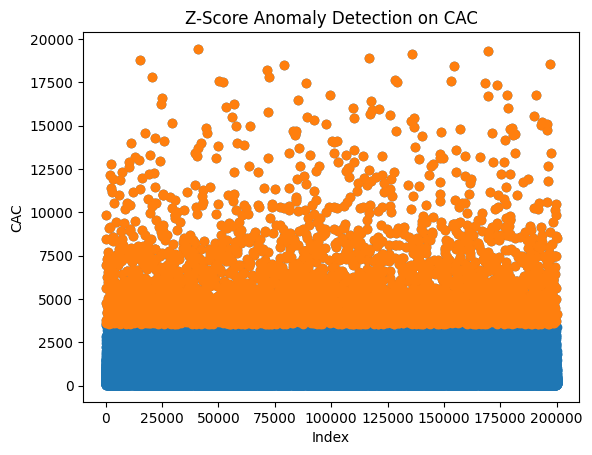

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df.index, df['cac'])
plt.scatter(df[df['is_anomaly'] == 1].index,
            df[df['is_anomaly'] == 1]['cac'])

plt.title("Z-Score Anomaly Detection on CAC")
plt.xlabel("Index")
plt.ylabel("CAC")
plt.show()

In [24]:
# Save processed dataset
df.to_csv('C:/Users/DarshBorse/Scikit/kpi/processed_marketing_data.csv', index=False)
df.shape

(200000, 24)

In [25]:
forecast_df = df[["date", "revenue"]].rename(columns={
    "date": "ds",
    "revenue": "y"
})

In [26]:
forecast_df = forecast_df.sort_values("ds")

In [27]:
!pip install prophet
from prophet import Prophet

model = Prophet()
model.fit(forecast_df)

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

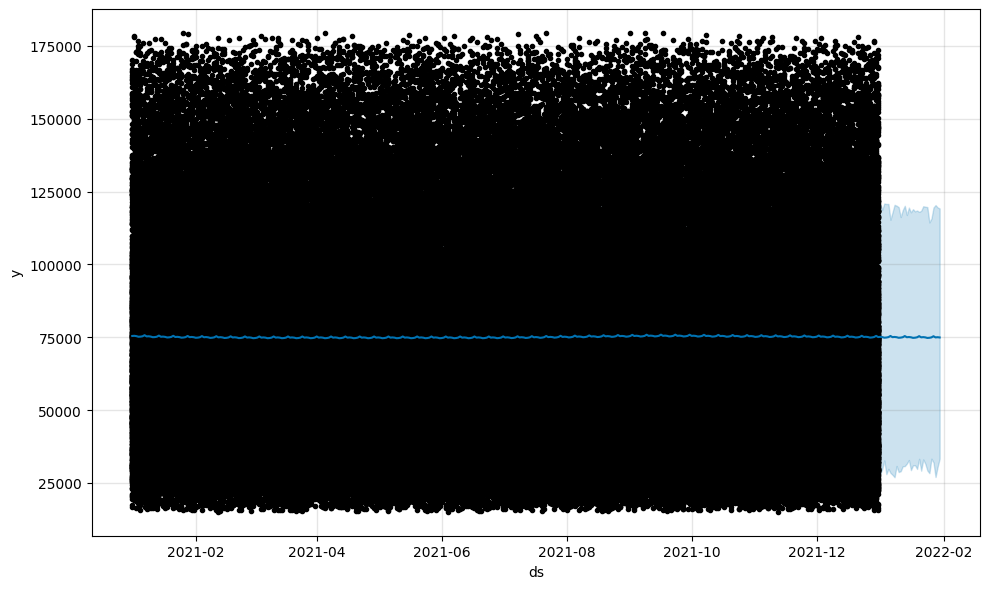

In [29]:
fig1 = model.plot(forecast)

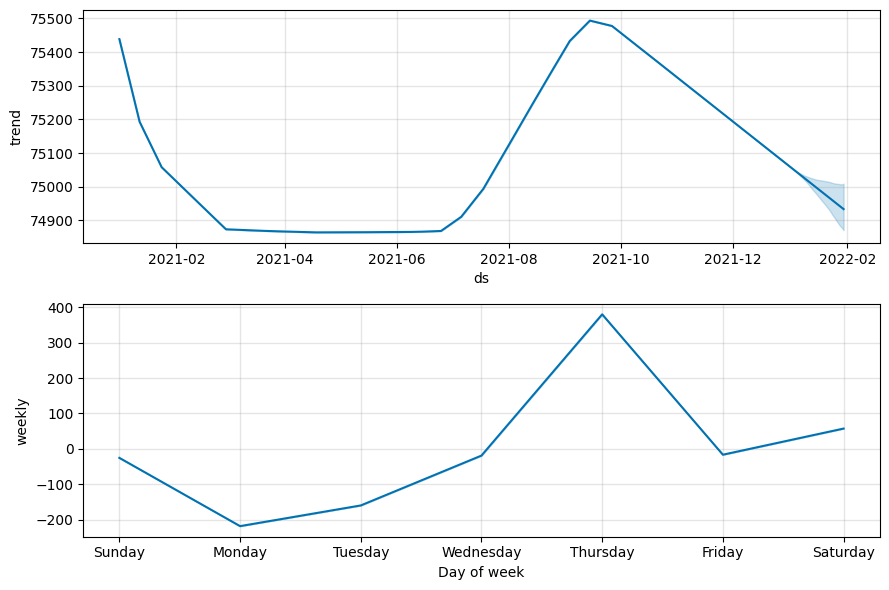

In [30]:
fig2 = model.plot_components(forecast)

In [31]:
future_forecast = forecast[forecast["ds"] > df["date"].max()]

In [32]:
future_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
365,2022-01-01,75116.425133,28078.644113,120810.921490
366,2022-01-02,75029.505932,29741.904424,118756.007908
367,2022-01-03,74832.729931,32706.307394,120884.633263
368,2022-01-04,74886.720585,27993.319867,120715.450949
369,2022-01-05,75022.992584,29797.960690,120744.010151


In [33]:
last_actual = df["revenue"].iloc[-1]
last_predicted = future_forecast["yhat"].iloc[-1]

growth_percent = ((last_predicted - last_actual) / last_actual) * 100

In [34]:
future_forecast["yhat"].iloc[-1] > last_actual

np.False_

In [35]:
future_forecast.to_csv("revenue_forecast_30_days.csv", index=False)

In [36]:
print(df['date'].dtype)

datetime64[ns]


In [37]:
df = df.sort_values('date')
df.head()

,campaign_id,company,campaign_type,duration,channel_used,conversion_rate,acquisition_cost,roi,location,language,...,date,revenue,conversions,cac,roas,region,gender,age_range,cac_zscore,is_anomaly
0,1,innovate industries,email,30,google ads,0.04,16174.0,6.29,chicago,spanish,...,2021-01-01,117908.46,20.24,799.110672,7.29,west,men,18-24,0.168823,0
145270,145271,datatech solutions,display,15,email,0.06,7382.0,7.77,los angeles,spanish,...,2021-01-01,64740.14,15.36,480.598958,8.77,north,women,35-44,-0.159493,0
198925,198926,innovate industries,email,60,youtube,0.10,15231.0,3.92,houston,mandarin,...,2021-01-01,74936.52,69.30,219.783550,4.92,south,men,18-24,-0.428336,0
18250,18251,innovate industries,search,45,facebook,0.08,13034.0,2.91,houston,spanish,...,2021-01-01,50962.94,14.24,915.308989,3.91,west,men,18-24,0.288597,0
144905,144906,datatech solutions,search,60,google ads,0.02,7126.0,4.19,chicago,english,...,2021-01-01,36983.94,14.26,499.719495,5.19,south,women,25-34,-0.139784,0


In [38]:
df['date'].is_monotonic_increasing

True

In [39]:
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
missing_dates = full_range.difference(df['date'])

print("Missing dates count:", len(missing_dates))
print(missing_dates[:10])

Missing dates count: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [40]:
import pandas as pd
import numpy as np

def generate_insights(df):
    insights = []

    # Ensure sorted by date
    df = df.sort_values('date')

    # ---- 1. Overall ROAS ----
    avg_roas = df['roas'].mean()
    if avg_roas >= 3:
        insights.append(f"Overall ROAS is strong at {avg_roas:.2f}x, indicating highly profitable campaigns.")
    elif avg_roas >= 2:
        insights.append(f"Overall ROAS is moderate at {avg_roas:.2f}x. Optimization can improve returns.")
    else:
        insights.append(f"Overall ROAS is low at {avg_roas:.2f}x. Marketing strategy may need adjustment.")

    # ---- 2. CAC Trend (Last 30 vs Previous 30 Days) ----
    last_30 = df.tail(30)
    prev_30 = df.iloc[-60:-30]

    if len(prev_30) > 0:
        cac_change = ((last_30['cac'].mean() - prev_30['cac'].mean()) / prev_30['cac'].mean()) * 100

        if cac_change > 5:
            insights.append(f"CAC increased by {cac_change:.1f}% in the last 30 days, indicating rising acquisition costs.")
        elif cac_change < -5:
            insights.append(f"CAC decreased by {abs(cac_change):.1f}% recently, improving cost efficiency.")
        else:
            insights.append("CAC remains relatively stable over the past month.")

    # ---- 3. Revenue Trend ----
    revenue_change = ((last_30['revenue'].sum() - prev_30['revenue'].sum()) / prev_30['revenue'].sum()) * 100 if len(prev_30) > 0 else 0

    if revenue_change > 5:
        insights.append(f"Revenue increased by {revenue_change:.1f}% in the last 30 days.")
    elif revenue_change < -5:
        insights.append(f"Revenue declined by {abs(revenue_change):.1f}% recently.")
    else:
        insights.append("Revenue is relatively stable compared to the previous period.")

    # ---- 4. Best Performing Campaign ----
    if 'campaign_type' in df.columns:
        campaign_roas = df.groupby('campaign_type')['roas'].mean()
        best_campaign = campaign_roas.idxmax()
        insights.append(f"{best_campaign} is the top-performing campaign based on average ROAS.")

    return insights

In [41]:
insights = generate_insights(df)

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

1. Overall ROAS is strong at 6.00x, indicating highly profitable campaigns.
2. CAC remains relatively stable over the past month.
3. Revenue increased by 17.4% in the last 30 days.
4. influencer is the top-performing campaign based on average ROAS.


In [42]:
def forecast_summary(df, forecast):
    insights = []

    # Get last 30 actual revenue
    last_30_actual = df.tail(30)['revenue'].sum()

    # Get next 30 predicted revenue
    future_forecast = forecast.tail(30)['yhat'].sum()

    growth = ((future_forecast - last_30_actual) / last_30_actual) * 100

    if growth > 5:
        insights.append(f"Forecast predicts a {growth:.1f}% revenue growth in the next 30 days.")
    elif growth < -5:
        insights.append(f"Forecast predicts a {abs(growth):.1f}% revenue decline next month.")
    else:
        insights.append("Revenue forecast suggests stable performance next month.")

    return insights

In [43]:
forecast_insights = forecast_summary(df, forecast)

for insight in forecast_insights:
    print(insight)

Revenue forecast suggests stable performance next month.


In [44]:
all_insights = generate_insights(df) + forecast_summary(df, forecast)

for i, insight in enumerate(all_insights, 1):
    print(f"{i}. {insight}")

1. Overall ROAS is strong at 6.00x, indicating highly profitable campaigns.
2. CAC remains relatively stable over the past month.
3. Revenue increased by 17.4% in the last 30 days.
4. influencer is the top-performing campaign based on average ROAS.
5. Revenue forecast suggests stable performance next month.


In [45]:
def explain_anomalies(df):
    explanations = []

    if 'is_anomaly' not in df.columns:
        return ["No anomaly column found."]

    anomalies = df[df['is_anomaly'] == 1]

    if anomalies.empty:
        return ["No significant anomalies detected."]

    for _, row in anomalies.iterrows():
        reason = []

        # Compare with overall averages
        if row['acquisition_cost'] > df['acquisition_cost'].mean() * 1.3:
            reason.append("Unusually high ad spend")

        if row['revenue'] < df['revenue'].mean() * 0.7:
            reason.append("Revenue drop")

        if row['cac'] > df['cac'].mean() * 1.3:
            reason.append("Spike in CAC")

        if row['roas'] < df['roas'].mean() * 0.7:
            reason.append("Low ROAS")

        explanation = ", ".join(reason) if reason else "Unusual KPI fluctuation"

        explanations.append(
            f"On {row['date'].date()}, anomaly detected due to: {explanation}."
        )

    return explanations

In [46]:
df.columns

Index(['campaign_id', 'company', 'campaign_type', 'duration', 'channel_used',
       'conversion_rate', 'acquisition_cost', 'roi', 'location', 'language',
       'clicks', 'impressions', 'engagement_score', 'customer_segment', 'date',
       'revenue', 'conversions', 'cac', 'roas', 'region', 'gender',
       'age_range', 'cac_zscore', 'is_anomaly'],
      dtype='object')

In [47]:
anomaly_explanations = explain_anomalies(df)

for explanation in anomaly_explanations[:5]:
    print(explanation)

On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC.
On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC.
On 2021-01-01, anomaly detected due to: Spike in CAC.
On 2021-01-01, anomaly detected due to: Spike in CAC.
On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC, Low ROAS.


In [48]:
def calculate_health_score(df):
    score = 100

    avg_roas = df['roas'].mean()
    avg_cac = df['cac'].mean()

    # ROAS impact
    if avg_roas < 2:
        score -= 25
    elif avg_roas < 3:
        score -= 10

    # CAC impact
    if avg_cac > df['cac'].quantile(0.75):
        score -= 20

    # Revenue trend impact
    last_30 = df.tail(30)['revenue'].sum()
    prev_30 = df.iloc[-60:-30]['revenue'].sum()

    if prev_30 > 0:
        growth = (last_30 - prev_30) / prev_30
        if growth < -0.05:
            score -= 20
        elif growth < 0:
            score -= 10

    return max(score, 0)

In [49]:
health_score = calculate_health_score(df)
print("Marketing Health Score:", health_score, "/ 100")

Marketing Health Score: 80 / 100


In [50]:
def generate_master_report(df, forecast):
    
    report = {}
    
    # 1️⃣ KPI Insights
    kpi_insights = generate_insights(df)
    
    # 2️⃣ Forecast Insights
    forecast_insights = forecast_summary(df, forecast)
    
    # 3️⃣ Anomaly Explanations
    anomaly_explanations = explain_anomalies(df)
    
    # 4️⃣ Health Score
    health_score = calculate_health_score(df)
    
    # Score Interpretation
    if health_score >= 80:
        score_status = "Strong Marketing Performance"
    elif health_score >= 60:
        score_status = "Moderate Performance – Optimization Recommended"
    else:
        score_status = "Critical – Immediate Strategy Adjustment Needed"
    
    # Combine into structured report
    report["Health Score"] = f"{health_score}/100 – {score_status}"
    report["KPI Insights"] = kpi_insights
    report["Forecast Insights"] = forecast_insights
    report["Anomaly Insights"] = anomaly_explanations
    
    return report

In [51]:
master_report = generate_master_report(df, forecast)

for section, content in master_report.items():
    print("\n", "="*50)
    print(section)
    print("="*50)
    
    if isinstance(content, list):
        for item in content:
            print("-", item)
    else:
        print(content)


Health Score
80/100 – Strong Marketing Performance

KPI Insights
- Overall ROAS is strong at 6.00x, indicating highly profitable campaigns.
- CAC remains relatively stable over the past month.
- Revenue increased by 17.4% in the last 30 days.
- influencer is the top-performing campaign based on average ROAS.

Forecast Insights
- Revenue forecast suggests stable performance next month.

Anomaly Insights
- On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC.
- On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC.
- On 2021-01-01, anomaly detected due to: Spike in CAC.
- On 2021-01-01, anomaly detected due to: Spike in CAC.
- On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC, Low ROAS.
- On 2021-01-01, anomaly detected due to: Spike in CAC.
- On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC.
- On 2021-01-01, anomaly detected due to: Unusually high ad spend, Spike in CAC.
- On 2021-

In [52]:
df["date"].unique()
df.shape

(200000, 24)

In [55]:
data=pd.read_csv("C:/Users/DarshBorse/Scikit/kpi/processed_marketing_data.csv")

In [ ]:
data['revenue']